## Exploration of LimeforTime with weather dataset

This notebook shows how to use the LimeforTime explainer to explain trained onnx model with weather dataset. <br>
Here is a notebook showing how to use LimeforTime explainer:<br>
https://github.com/emanuel-metzenthin/Lime-For-Time/blob/master/demo/LIME-Pipeline.ipynb

### Load weather dataset

In [1]:
import os
import pandas as pd
import numpy as np
from lime_timeseries import LimeTimeSeriesExplainer
from scipy.special import softmax
from sklearn.model_selection import train_test_split

import onnx
import onnxruntime as ort

In [2]:
np.random.seed(42)

In [ ]:
# download data from Zenodo
fname = "weather_prediction_dataset_light.csv"
if os.path.isfile(fname):
    data = pd.read_csv(fname)
else:
    data = pd.read_csv(f"https://zenodo.org/record/5071376/files/{fname}?download=1")
data.describe()

In [3]:
# use data from github https://github.com/florian-huber/weather_prediction_dataset
# fname = "weather_prediction_dataset.csv"
# data = pd.read_csv(fname)
# data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,5.104215,11.470635,3.677258,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,7.250744,8.950217,1.519866,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


### Prepare dataset
Given how the classification model is trained, we prepare the testing data for prediction.

In [4]:
# select only data from De Bilt
columns = [col for col in data.columns if col.startswith('DE_BILT')]#[:9]
data_debilt = data[columns]
data_debilt.describe()

,DE_BILT_cloud_cover,DE_BILT_wind_speed,DE_BILT_wind_gust,DE_BILT_humidity,DE_BILT_pressure,DE_BILT_global_radiation,DE_BILT_precipitation,DE_BILT_sunshine,DE_BILT_temp_mean
count,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.00000
mean,5.303229,3.395293,9.986316,0.817882,1.015299,1.190903,0.236888,4.744444,10.70353
std,2.279416,1.422020,3.582408,0.097465,0.009861,0.870267,0.459495,3.995637,6.19077
min,0.000000,0.700000,2.000000,0.370000,0.973200,0.110000,0.000000,0.000000,-7.90000
25%,4.000000,2.300000,7.000000,0.760000,1.009400,0.410000,0.000000,1.100000,6.20000
50%,6.000000,3.200000,10.000000,0.830000,1.015700,1.020000,0.010000,4.100000,11.00000
75%,7.000000,4.200000,12.000000,0.890000,1.021700,1.860000,0.290000,7.500000,15.50000
max,8.000000,10.300000,28.000000,1.000000,1.044900,3.410000,4.250000,15.500000,26.90000


In [5]:
# find where the month changes
idx = np.where(np.diff(data['MONTH']) != 0)[0]
# idx contains the index of the last day of each month, except for the last month.
# of the last month only a single day is recorded, so we discard it.

nmonth = len(idx)
# add start of first month
idx = np.insert(idx, 0, 0)
ncol = len(columns)
# create single object containing each timeseries
# for simplicity we truncate each timeseries to the same length, i.e. 28 days
nday = 28
data_ts = np.zeros((nmonth, nday, ncol))
for m in range(nmonth):
    data_ts[m] = data_debilt[idx[m]:idx[m+1]][:28]
    
print(data_ts.shape)

(120, 28, 9)


In [6]:
# the labels are based on the month of each timeseries, in range 1 to 12
months = (np.arange(nmonth) + data['MONTH'][0] - 1) % 12 + 1

# one class per meteorological season
labels = np.zeros_like(months, dtype=int)
spring = (3 <= months) & (months <= 5)   # mar - may
summer = (6 <= months) & (months <= 8)   # jun - aug
autumn = (9 <= months) & (months <= 11)  # sep - nov
winter = (months <= 2) | (months == 12)  # dec - feb

labels[spring] = 0
labels[summer] = 1
labels[autumn] = 2
labels[winter] = 3

target = pd.get_dummies(labels)

classes = ['spring', 'summer', 'autumn', 'winter']
nclass = len(classes)

target.describe()

,0,1,2,3
count,120.000000,120.000000,120.000000,120.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.434828,0.434828,0.434828,0.434828
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000


### Train/test split

In [7]:
data_trainval, data_test, target_trainval, target_test = train_test_split(data_ts, target, stratify=target, random_state=0, test_size=.12)
data_train, data_val, target_train, target_val = train_test_split(data_trainval, target_trainval, stratify=target_trainval, random_state=0, test_size=.12)
print(data_train.shape, data_val.shape, data_test.shape)

(92, 28, 9) (13, 28, 9) (15, 28, 9)


### Check predictions with ONNX model

In [8]:
# onnx model available on surf drive
# path to ONNX model
onnx_file = 'season_prediction_model.onnx'

# verify the ONNX model is valid
onnx_model = onnx.load(onnx_file)
onnx.checker.check_model(onnx_model)

In [9]:
def run_model(data):
    # model must receive input in the order of [batch, timeseries, channels]
    data = data.transpose([0,2,1])
    print(data.shape)
    # get ONNX predictions
    sess = ort.InferenceSession(onnx_file)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    
    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [10]:
idx = 5 # explained instance
data_instance = data_test[idx][np.newaxis, ...]
# precheck ONNX predictions
# pred_onnx = run_model(data_instance)
# pred_class = classes[np.argmax(pred_onnx)]
# print("The predicted class is:", pred_class)
# print("The actual class is:", classes[np.argmax(target_test.iloc[idx])])

In [11]:
num_features = 9 # how many feature contained in explanation
num_slices = 14 # split time series

In [12]:
explainer = LimeTimeSeriesExplainer(class_names=classes, signal_names = columns) # for multi-variate series, signal_names must be provided
exp = explainer.explain_instance(data_instance[0].T, run_model, num_features=num_features, num_samples=500, num_slices=num_slices, 
                                 replacement_method='total_mean')
#exp.as_pyplot_figure()

(500, 9, 28)
(500, 28, 9)


In [13]:
exp.as_list()

_id 16
weight 0.024724749778960522
nsignal 1
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean']
_id 113
weight 0.023187065143560604
nsignal 8
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean']
_id 30
weight 0.021641358500839897
nsignal 2
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean']
_id 32
weight -0.01713256331566774
nsignal 2
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_

[('2 - DE_BILT_wind_speed', 0.024724749778960522),
 ('1 - DE_BILT_temp_mean', 0.023187065143560604),
 ('2 - DE_BILT_wind_gust', 0.021641358500839897),
 ('4 - DE_BILT_wind_gust', -0.01713256331566774),
 ('3 - DE_BILT_wind_gust', 0.0062870923052700655),
 ('2 - DE_BILT_cloud_cover', -0.006080304848573974),
 ('3 - DE_BILT_sunshine', -0.0023176137054986955),
 ('4 - DE_BILT_cloud_cover', -0.0019278312003246877),
 ('5 - DE_BILT_wind_gust', -1.6701048910318338e-06)]

_id 16
weight 0.024724749778960522
nsignal 1
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean']
_id 113
weight 0.023187065143560604
nsignal 8
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean']
_id 30
weight 0.021641358500839897
nsignal 2
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean']
_id 32
weight -0.01713256331566774
nsignal 2
self.signal_names=['DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_

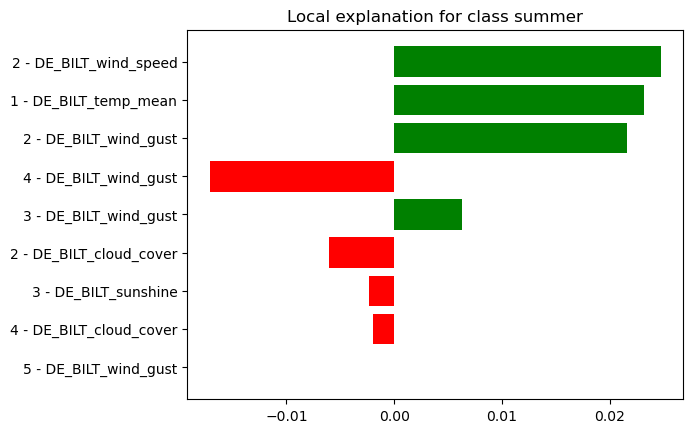

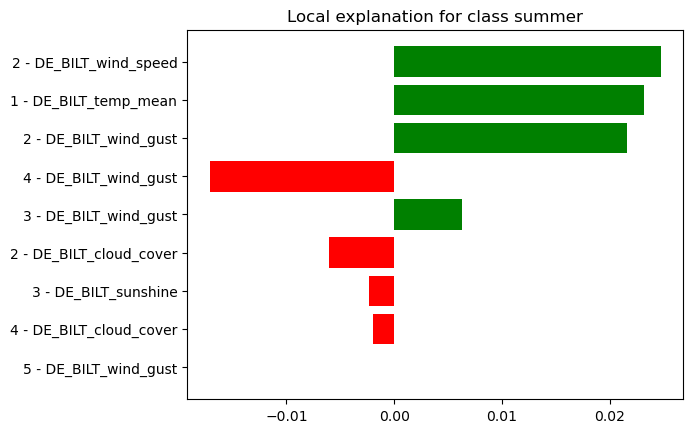

In [14]:
exp.as_pyplot_figure()